In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tqdm import tqdm

# from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ratemeter/sample_submission.csv
/kaggle/input/ratemeter/train.csv
/kaggle/input/ratemeter/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/ratemeter/train.csv')
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [4]:
# train = train.iloc[:1000]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       630000 non-null  object
 1   book_id       630000 non-null  int64 
 2   review_id     630000 non-null  object
 3   review_text   630000 non-null  object
 4   date_added    630000 non-null  object
 5   date_updated  630000 non-null  object
 6   read_at       565775 non-null  object
 7   started_at    437963 non-null  object
 8   n_votes       630000 non-null  int64 
 9   n_comments    630000 non-null  int64 
 10  rating        630000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 52.9+ MB


In [5]:
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,I finished this in two days. THIS SERIES IS JU...,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,Review to follow \n Goodreads 4 \n Amazon 5 \n...,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,I will have a full review up eventually but fo...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,4 stars. Aww! I loved this one! I have read th...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,this is official: Patrick Ness is my fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [6]:
train['rating'].value_counts()

rating
4    219581
5    185505
3    132280
2     50839
0     21692
1     20103
Name: count, dtype: int64

In [7]:
# Text Lowercasing
train['review_text'] = train['review_text'].str.lower()

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_processing(text):
    text = re.sub(r"http\S+", "", text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = decontracted(text)
    return text

In [9]:
# Decontracting , removing html tags ang removing links
train['review_text'] = train['review_text'].apply(text_processing)

/tmp/ipykernel_47/2697240764.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [10]:
# Tokenization
train['review_text'] = train['review_text'].apply(word_tokenize)

In [11]:
# Remove Punctuation and Non-Alphabetic Characters
train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [12]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
train['review_text'] = train['review_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [13]:
# Stemmatizing
snow_stemmer = nltk.stem.SnowballStemmer('english')

train['review_text'] = train['review_text'].apply(lambda x: [snow_stemmer.stem(word) for word in x])

In [14]:
#  Reconstruct the Text
train['review_text'] = train['review_text'].apply(lambda tokens: ' '.join(tokens))
train.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,rating
0,1c845473e18c23f917126cb29bc8d243,6547260,5805e560deacf886537b2e76b2653515,finish two day seri good stop fuck end,Sat Nov 16 00:26:42 -0800 2013,Mon Jan 26 11:14:39 -0800 2015,Mon Jan 26 11:14:39 -0800 2015,Sat Jan 24 00:00:00 -0800 2015,0,0,5
1,0867fa7e18da1a292d0256fad0ee4e31,17201095,84c2e89581004bedd01dea2833bed181,review follow goodread amazon overal,Wed Jan 02 11:22:44 -0800 2013,Sun Apr 28 20:23:22 -0700 2013,NaN,NaN,0,0,5
2,a57237ef712461148672852d8f47e300,16143347,956d4ea003698d83c1495cc251be5bc0,full review eventu initi hope thought shake br...,Thu Jun 19 15:48:04 -0700 2014,Thu May 05 09:09:58 -0700 2016,Thu Jun 19 00:00:00 -0700 2014,Thu Jun 19 00:00:00 -0700 2014,0,0,5
3,80589c77f4fa826eaaf7c5d71ff3b81e,7863423,e5ed7e0401cbe5c44e7b7ee4e1af4f09,star aww love one read seri order even though ...,Wed Sep 16 18:52:06 -0700 2015,Sun Sep 20 18:34:34 -0700 2015,Sun Sep 20 00:00:00 -0700 2015,Sat Sep 19 00:00:00 -0700 2015,1,0,4
4,916977f433fbf96ae9de9669f8aec040,17262303,51b4449f83ff8c9d13a3b6aa2df4fb27,offici patrick ness fav author,Sun Oct 13 11:47:17 -0700 2013,Mon Sep 15 17:51:03 -0700 2014,Tue Sep 16 17:51:03 -0700 2014,NaN,0,0,5


In [15]:
train['date_added'] = train['date_added'].apply(lambda date: date.split()[-1])
train['date_updated'] = train['date_updated'].apply(lambda date: date.split()[-1])

In [16]:
train = train[['book_id','review_text','date_added','date_updated','n_votes','n_comments','rating']]
# train = train[['review_text','rating']]

In [17]:
train.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,rating
0,6547260,finish two day seri good stop fuck end,2013,2015,0,0,5
1,17201095,review follow goodread amazon overal,2013,2013,0,0,5
2,16143347,full review eventu initi hope thought shake br...,2014,2016,0,0,5
3,7863423,star aww love one read seri order even though ...,2015,2015,1,0,4
4,17262303,offici patrick ness fav author,2013,2014,0,0,5


In [18]:
train['book_id'] = train['book_id'].astype("int64")
train['date_added'] = train['date_added'].astype("int64")
train['date_updated'] = train['date_updated'].astype("int64")
train['n_votes'] = train['n_votes'].astype("int64")
train['n_comments'] = train['n_comments'].astype("int64")
train['rating'] = train['rating'].astype("int64")

In [19]:
def normalize(df):
    result = df.copy()
    for feature_name in ['book_id','date_added','date_updated','n_votes','n_comments']:
        if(feature_name == 'book_id'):
            max_value = 40000000
            min_value = 0
        if(feature_name == 'date_updated' or feature_name == 'date_added'):
            max_value = 2018
            min_value = 2005
        else:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

train = normalize(train)
train.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,rating
0,0.180223,finish two day seri good stop fuck end,0.615385,0.769231,0.000946,0.000749,5
1,0.473485,review follow goodread amazon overal,0.615385,0.615385,0.000946,0.000749,5
2,0.444369,full review eventu initi hope thought shake br...,0.692308,0.846154,0.000946,0.000749,5
3,0.216452,star aww love one read seri order even though ...,0.769231,0.769231,0.001262,0.000749,4
4,0.475170,offici patrick ness fav author,0.615385,0.692308,0.000946,0.000749,5


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   book_id       630000 non-null  float64
 1   review_text   630000 non-null  object 
 2   date_added    630000 non-null  float64
 3   date_updated  630000 non-null  float64
 4   n_votes       630000 non-null  float64
 5   n_comments    630000 non-null  float64
 6   rating        630000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 33.6+ MB


In [21]:
# saving the dataframe
train.to_csv('train.csv',header=True,index=False)

In [22]:
# Open a file and use dump() 
with open('preprocessed.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(train, file) 

In [23]:
# Open the file in binary mode 
with open('preprocessed.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    train = pickle.load(file) 

<Axes: >

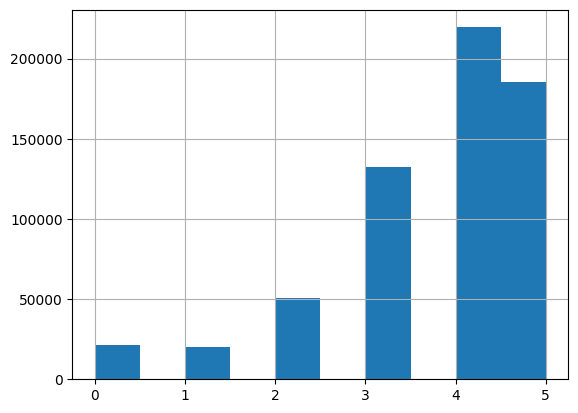

In [24]:
train["rating"].hist()

In [25]:
train.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments,rating
0,0.180223,finish two day seri good stop fuck end,0.615385,0.769231,0.000946,0.000749,5
1,0.473485,review follow goodread amazon overal,0.615385,0.615385,0.000946,0.000749,5
2,0.444369,full review eventu initi hope thought shake br...,0.692308,0.846154,0.000946,0.000749,5
3,0.216452,star aww love one read seri order even though ...,0.769231,0.769231,0.001262,0.000749,4
4,0.475170,offici patrick ness fav author,0.615385,0.692308,0.000946,0.000749,5


In [26]:
X = train['review_text']
y = train['rating']

In [27]:
# Tokenize text data
max_words = 10000  # Maximum number of words to keep based on frequency
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

In [28]:
# Convert text data to sequences and pad sequences for uniform length
max_sequence_length = 200  # Assuming maximum sequence length
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)

In [29]:
# Convert labels to categorical values
num_classes = len(train['rating'].unique())  # Number of unique classes
y_categorical = pd.get_dummies(y)

In [30]:
print(num_classes)

6


In [31]:
print(train['book_id'].max())
print(train['book_id'].min())

1.0
0.0


In [32]:
print(train['date_updated'].max())
print(train['date_updated'].min())

0.9230769230769231
0.07692307692307693


In [33]:
# Calculate correlation matrix
correlation_matrix = train[['book_id','date_added','date_updated','n_votes','n_comments','rating']].corr()

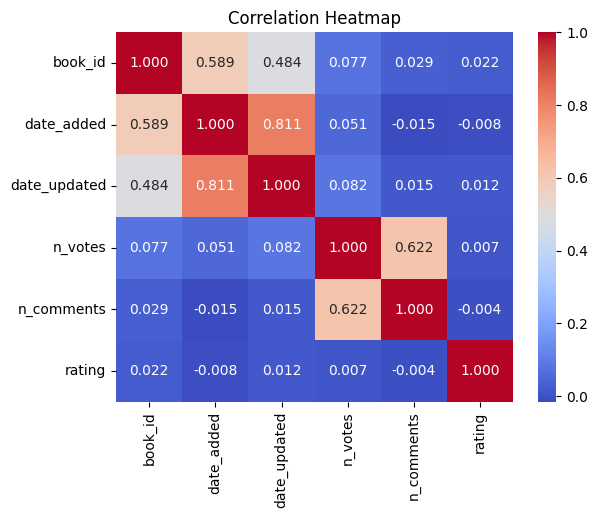

In [34]:
# Plot Heat map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap')
plt.show()

In [35]:
X_features = train[['date_updated', 'n_votes', 'n_comments']]
X_features = X_features.to_numpy()
print(X_features.shape)
print(X_features)
print(type(X_features))

(630000, 3)
[[7.69230769e-01 9.46372240e-04 7.48502994e-04]
 [6.15384615e-01 9.46372240e-04 7.48502994e-04]
 [8.46153846e-01 9.46372240e-04 7.48502994e-04]
 ...
 [7.69230769e-01 1.26182965e-03 7.48502994e-04]
 [6.15384615e-01 9.46372240e-04 7.48502994e-04]
 [8.46153846e-01 1.26182965e-03 7.48502994e-04]]
<class 'numpy.ndarray'>


In [36]:
# Combine text and numerical features
X_combined = np.concatenate((X_padded, X_features), axis=1)

In [37]:
X_combined.shape

(630000, 203)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_categorical, test_size=0.2, random_state=42)

In [39]:
# Building the model
embedding_dim = 150  # Dimension of the embedding layer
lstm_units = 64  # Number of LSTM units

In [40]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length+3),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(units=64)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [41]:
# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 203, 150)          1500000   
                                                                 
 bidirectional (Bidirection  (None, 203, 128)          110080    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 203, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               1

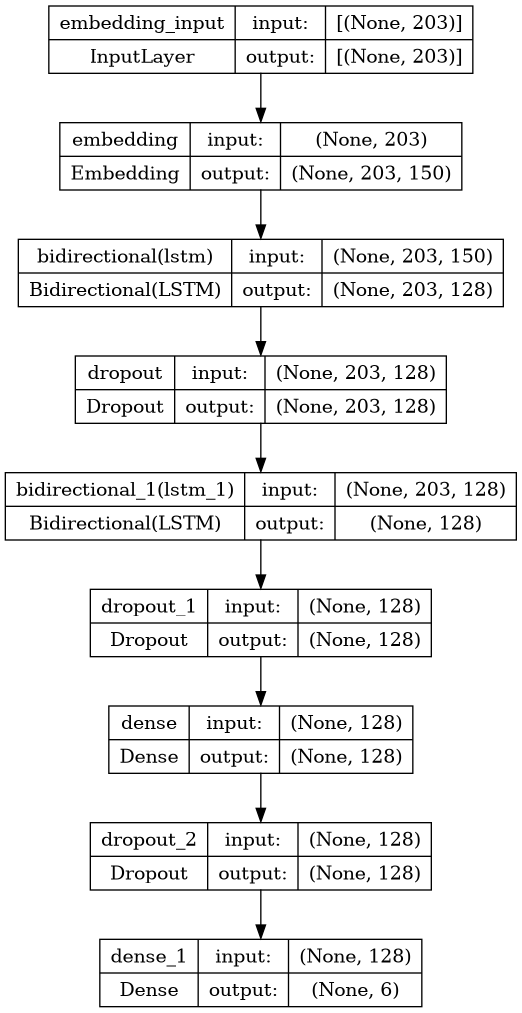

In [43]:
keras.utils.plot_model(model, show_shapes=True)

In [44]:
class Config:
    batch_size = 64
    epochs = 20
    validation_split = 0.2
    model_path = "model.tf"
config = Config()

In [45]:
# Training the model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True,),
    tf.keras.callbacks.ModelCheckpoint(config.model_path, save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only=True),
]

# checkpoint = keras.callbacks.ModelCheckpoint(config.model_path, save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only=True)
history = model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_split=config.validation_split, callbacks=my_callbacks)
model.load_weights(config.model_path)


Epoch 1/20
6300/6300 [==============================] - 347s 53ms/step - loss: 1.1861 - accuracy: 0.4927 - val_loss: 1.1095 - val_accuracy: 0.5217
Epoch 2/20
6300/6300 [==============================] - 204s 32ms/step - loss: 1.0896 - accuracy: 0.5363 - val_loss: 1.0902 - val_accuracy: 0.5290
Epoch 3/20
6300/6300 [==============================] - 199s 32ms/step - loss: 1.0439 - accuracy: 0.5570 - val_loss: 1.0711 - val_accuracy: 0.5441
Epoch 4/20
6300/6300 [==============================] - 198s 31ms/step - loss: 1.0058 - accuracy: 0.5749 - val_loss: 1.0745 - val_accuracy: 0.5429
Epoch 5/20
6300/6300 [==============================] - 195s 31ms/step - loss: 0.9672 - accuracy: 0.5927 - val_loss: 1.0860 - val_accuracy: 0.5431
Epoch 6/20
6300/6300 [==============================] - 195s 31ms/step - loss: 0.9294 - accuracy: 0.6112 - val_loss: 1.1200 - val_accuracy: 0.5347
Epoch 7/20
6300/6300 [==============================] - 194s 31ms/step - loss: 0.8909 - accuracy: 0.6310 - val_loss: 1

In [46]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

3938/3938 [==============================] - 48s 12ms/step - loss: 1.0659 - accuracy: 0.5462
Test Accuracy: 0.5462063550949097


<Axes: >

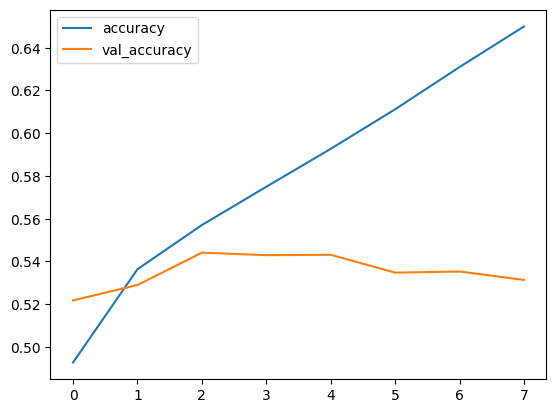

In [47]:
his=pd.DataFrame(history.history)
his = his[['accuracy','val_accuracy']]
his.plot()

In [48]:
X_test.shape

(126000, 203)

In [49]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_pred.shape

3938/3938 [==============================] - 45s 11ms/step


(126000,)

In [50]:
y_test.shape

(126000, 6)

In [51]:
categorical_y_test = np.argmax(y_test, axis=1)
print(categorical_y_test)
print(categorical_y_test.shape)

[4 4 4 ... 5 4 5]
(126000,)


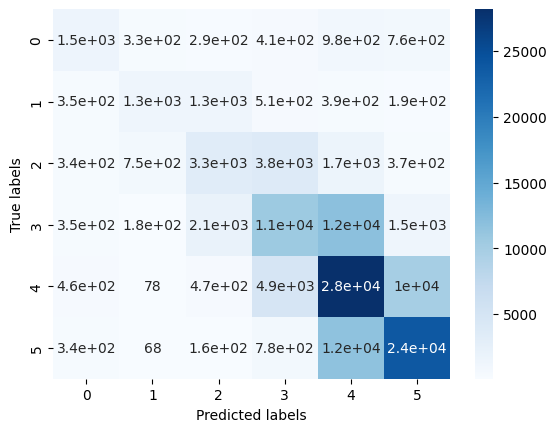

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(categorical_y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [53]:
cls_report = classification_report(categorical_y_test, y_pred)
print(cls_report)

              precision    recall  f1-score   support

           0       0.45      0.35      0.40      4299
           1       0.48      0.32      0.38      4016
           2       0.43      0.32      0.37     10223
           3       0.51      0.40      0.45     26625
           4       0.51      0.64      0.57     44011
           5       0.65      0.65      0.65     36826

    accuracy                           0.55    126000
   macro avg       0.51      0.45      0.47    126000
weighted avg       0.54      0.55      0.54    126000



In [78]:
test = pd.read_csv('/kaggle/input/ratemeter/test.csv')
test_original = test
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,de3a6a28c83cda006b415d45d64674c9,1618,d76ce5becf493e5c653610edb806ffc4,"I'm going to keep this review short, because I...",Tue Jun 09 10:37:48 -0700 2015,Wed Jun 10 13:43:38 -0700 2015,Wed Jun 10 14:08:39 -0700 2015,Tue Jun 09 00:00:00 -0700 2015,8,0
1,d9cfab35a87e32084b1817dfb0e98748,15776309,9c5c9aed79255a1a610dfc153ee90ad6,"You know, I was really stoked to see this come...",Mon Apr 22 09:19:40 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Wed Jul 10 14:34:27 -0700 2013,Tue Jul 09 00:00:00 -0700 2013,0,0
2,24935a870a46525a37be92775ab18f76,478927,ad26332459cda8f40581fef7a29b800c,This is one of those books where you know you ...,Sat Mar 14 12:16:55 -0700 2015,Sun Apr 05 11:25:00 -0700 2015,Wed Mar 18 00:00:00 -0700 2015,Sat Mar 14 00:00:00 -0700 2015,14,0
3,6ccb40eabdd0db7895aac00963256469,22628,5bb75768be7f2ddcd632336778b67f5a,The perks of being a wallflower \n What does a...,Sat Sep 12 08:43:30 -0700 2015,Sat Sep 12 09:19:29 -0700 2015,NaN,NaN,0,0
4,9f9d0f6e9a6a5797a252ef81abc9421c,13596809,3d7f76ea566b9ce0700772236094d936,"So, I wrote a review for this when I read it b...",Sun Jul 14 19:36:13 -0700 2013,Thu Jun 02 16:45:45 -0700 2016,Sat Mar 23 00:00:00 -0700 2013,NaN,0,0


In [79]:
# test_original = test_original.iloc[:500]
# test = test.iloc[:500]
test.shape

(270000, 10)

In [80]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       270000 non-null  object
 1   book_id       270000 non-null  int64 
 2   review_id     270000 non-null  object
 3   review_text   270000 non-null  object
 4   date_added    270000 non-null  object
 5   date_updated  270000 non-null  object
 6   read_at       242459 non-null  object
 7   started_at    187740 non-null  object
 8   n_votes       270000 non-null  int64 
 9   n_comments    270000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 20.6+ MB


In [81]:
# Text Lowercasing
test['review_text'] = test['review_text'].str.lower()

In [82]:
# Decontracting , removing html tags ang removing links
test['review_text'] = test['review_text'].apply(text_processing)

/tmp/ipykernel_47/2697240764.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [83]:
# Tokenization
test['review_text'] = test['review_text'].apply(word_tokenize)

In [84]:
# Remove Punctuation and Non-Alphabetic Characters
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [85]:
# Remove Punctuation and Non-Alphabetic Characters
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

In [86]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))
test['review_text'] = test['review_text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

In [87]:
# Stemmatizing
snow_stemmer = nltk.stem.SnowballStemmer('english')

test['review_text'] = test['review_text'].apply(lambda x: [snow_stemmer.stem(word) for word in x])

In [88]:
#  Reconstruct the Text
test['review_text'] = test['review_text'].apply(lambda tokens: ' '.join(tokens))

In [89]:
test['date_added'] = test['date_added'].apply(lambda date: date.split()[-1])
test['date_updated'] = test['date_updated'].apply(lambda date: date.split()[-1])

In [90]:
test = test[['book_id','review_text','date_added','date_updated','n_votes','n_comments']]

In [91]:
# Open a file and use dump() 
with open('preprocessed_test.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(test, file) 

In [92]:
# Open the file in binary mode 
with open('preprocessed_test.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    test = pickle.load(file) 

In [93]:
X_test_rnn_seq = tokenizer.texts_to_sequences(test['review_text'])
X_test_rnn_seq_padded = pad_sequences(X_test_rnn_seq, maxlen=max_sequence_length)

In [94]:
test['book_id'] = test['book_id'].astype("int64")
test['date_added'] = test['date_added'].astype("int64")
test['date_updated'] = test['date_updated'].astype("int64")
test['n_votes'] = test['n_votes'].astype("int64")
test['n_comments'] = test['n_comments'].astype("int64")

In [95]:
test = normalize(test)
test.head()

,book_id,review_text,date_added,date_updated,n_votes,n_comments
0,0.000045,go keep review short feel like danger touchi s...,0.769231,0.769231,0.003102,0.001242
1,0.434266,know realli stoke see come librari websit read...,0.615385,0.615385,0.000620,0.001242
2,0.013183,one book know want read year ago dream come tr...,0.769231,0.769231,0.004963,0.001242
3,0.000623,perk wallflow wallflow mean question edg pick ...,0.769231,0.769231,0.000620,0.001242
4,0.374272,wrote review read accident delet whole bunch r...,0.615385,0.846154,0.000620,0.001242


In [96]:
X_test_features = test[['date_updated', 'n_votes', 'n_comments']]
X_test_features = X_test_features.to_numpy()
print(X_test_features.shape)
print(X_test_features)
print(type(X_test_features))

(270000, 3)
[[7.69230769e-01 3.10173697e-03 1.24223602e-03]
 [6.15384615e-01 6.20347395e-04 1.24223602e-03]
 [7.69230769e-01 4.96277916e-03 1.24223602e-03]
 ...
 [9.23076923e-01 6.20347395e-04 1.24223602e-03]
 [7.69230769e-01 6.20347395e-04 1.24223602e-03]
 [8.46153846e-01 9.30521092e-04 1.24223602e-03]]
<class 'numpy.ndarray'>


In [97]:
# Combine text and numerical features
X_test_combined = np.concatenate((X_test_rnn_seq_padded, X_test_features), axis=1)

In [98]:
X_test_combined.shape

(270000, 203)

In [99]:
y_pred_rnn = model.predict(X_test_combined)
y_pred_rnn = np.argmax(y_pred_rnn, axis=-1)
y_pred_rnn.shape

8438/8438 [==============================] - 94s 11ms/step


(270000,)

In [100]:
review_id_list = test_original['review_id'].to_numpy()
print(review_id_list[:10])
print(type(review_id_list))
print(review_id_list.shape)

['d76ce5becf493e5c653610edb806ffc4' '9c5c9aed79255a1a610dfc153ee90ad6'
 'ad26332459cda8f40581fef7a29b800c' '5bb75768be7f2ddcd632336778b67f5a'
 '3d7f76ea566b9ce0700772236094d936' 'ce5c9f3f6c9dbb7e1a141265d773e842'
 'fb280e8ecb1a6edf3fa511ba7a304dd6' '1ac5f014d18943fb5142d6f65bda688b'
 '9a959c707757a216447029b51ebb84d2' '43c72b5942588a51ec18600b36d064de']
<class 'numpy.ndarray'>
(270000,)


In [101]:
data_rnn = {'review_id': review_id_list,
        'rating': y_pred_rnn}


output_df_rnn = pd.DataFrame(data_rnn)
print(output_df_rnn.shape)
output_df_rnn.head()

(270000, 2)


,review_id,rating
0,d76ce5becf493e5c653610edb806ffc4,4
1,9c5c9aed79255a1a610dfc153ee90ad6,2
2,ad26332459cda8f40581fef7a29b800c,5
3,5bb75768be7f2ddcd632336778b67f5a,5
4,3d7f76ea566b9ce0700772236094d936,5


In [102]:
# saving the dataframe
output_df_rnn.to_csv('output_rnn_.csv',header=True,index=False)

In [103]:
# saving the dataframe
output_df_rnn.to_csv('output_rnn_new.csv',header=True,index=False)